<a href="https://colab.research.google.com/github/olga-terekhova/data-analysis/blob/main/vendor-extracurriculars-choice/vendor-extracurriculars-choice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

A vendor offers extracurricular activities in Toronto schools, including a lot of TDSB schools.   

We want to analyse what kind of schools are more likely to be chosen by this vendor. Our hypothesis is the vendor predominantly selects schools with more affluent families. To confirm this we use two characteristics of TDSB schools:  
1) Learning Opportunity Index calculated by TDSB  
2) Presence of Early French Immersion stream in TDSB schools  

## To-do

1) Handle the cases when the vendor merged two schools into one record  

# Analysis

## Install, import, initialize libraries

In [1]:
# install libraries for pymupdf (pdf processing) and pillow (picture processing)
! pip install -q pymupdf pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 24.5 MB/s eta 0:00:00


In [2]:
# install libraries to extract tables from pdf
!pip install -q tabula-py
!pip install -q jpype1
#!pip install -q matplotlib_venn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 5.1 MB/s eta 0:00:00


In [3]:
# install pyspark and findspark
!pip install -q pyspark findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
# import libraries
import requests
import re
import tabula
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

In [5]:
# import and initialize spark
import findspark
findspark.init()

In [6]:
# import names from pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pyspark.sql.types as pys_types

In [7]:
# initialize spark session
spark = SparkSession.builder.appName("vendor-extracurriculars-choice").getOrCreate()

In [8]:
# set the notebook in debug mode by making debug_ind == 1
# set the notebook in production mode by making debug_ind == 0
# use df_show function to show spark dataframes. it will only actually show in the debug mode
# otherwise it will not show dataframes and will not trigger calculations

debug_ind = 1

def df_show(df):
  if debug_ind == 1:
    df.show(n=5, truncate = False)

##Download source data file

Download source files with:  
- LOI index data from TDSB,  
- list of schools with extracurriculars offered from the vendor,  
- list of schoold with Early Immersion stream from TDSB.  

Save the files locally.

### Define common functions

#### Define a function for downloading files

In [9]:
# download file from url to path
def download_file(url, path):
  response = requests.get(url)
  with open(path, 'wb') as f:
    f.write(response.content)

### Download LOI index

In [10]:
# download file with LOI index data
pdf_url = "https://github.com/olga-terekhova/data-analysis/raw/main/vendor-extracurriculars-choice/data/LOI2023.pdf"
pdf_path = 'LOI2023.pdf'
download_file(pdf_url, pdf_path)

### Download vendor classes availability by school

In [11]:
# Download the file with list of schools
url_v = "https://raw.githubusercontent.com/olga-terekhova/data-analysis/main/vendor-extracurriculars-choice/data/find_your_school"
path_v = 'find_your_school'
download_file(url_v, path_v)

### Download Early French Immersion schools

In [12]:
# download the file with the list of Early Immersion schools
url_f = "https://github.com/olga-terekhova/data-analysis/raw/main/vendor-extracurriculars-choice/data/TDSB_EarlyImmersion_Schools.txt"
path_f = 'FI.txt'
download_file(url_f, path_f)

## Create datasets

Create Spark dataframes from the source files.  

### Define common functions

#### Check pdf area boundaries

Check that the boundaries identified for tables within pdf contain the target area. The script creates snapshots for the selected area for all pages with tables.  
This function should be run iteratively to find the coordinates of the rectangle which will be fed into tabula table extraction.  
Once the coordinates are established, no need to run it anymore, so it's normally commented out.  

NB: area notation for fizz is (left, top, right, bottom), while tabula uses (top, left, bottom, right)

In [13]:
def download_area_pictures(pdf_path, output_name, range_start, range_end, left, top, right, bottom):
  import fitz  # PyMuPDF
  from PIL import Image # pillow

  # Open the PDF file
  document = fitz.open(pdf_path)

  for i in range(range_start-1,range_end):
    # Select current page
    page = document[i]

    # Specify the rectangular area (coordinates in points)
    rect = fitz.Rect(left, top, right, bottom)

    # Get the image of the specified rectangular area
    pix = page.get_pixmap(clip=rect)

    # Save the image
    image_path = output_name + str(i) + '.png'
    pix.save(image_path)

    # Convert the pixmap to a PIL Image
    image = Image.open(image_path)

# uncomment next line to run the function
# download_area_pictures(pdf_path, "output", 7, 21, 20, 105, 770, 560)

#20, 105, 770, 560 for LOI tables -- the coordinates for the images
# feed the coordinates into tabula as 105, 20, 560, 770

### Extract dataframe with LOI index

In [14]:
# define list of column names
table_header = ['School ID', 'School Name', 'LOI 2023 Rank', 'LOI 2020 Rank', 'LOI 2017 Rank', 'LOI 2014 Rank', 'LOI 2011 Rank', 'LOI Scores', 'Ward', 'Learning Centre']

In [15]:
# read all pdf tables into a single pandas dataframe with no headers
dfs = tabula.read_pdf(pdf_path, stream=True, pages="7-21", area=[105, 20, 560, 770], pandas_options={'header': None}, multiple_tables=False)

# read the single dataframe from the first array item
df = dfs[0]

# assign column names
df.columns = table_header

In [16]:
# handle nulls for years with absent LOI and converting float into int
df['LOI 2023 Rank'] = df['LOI 2023 Rank'].fillna(0).astype(int)
df['LOI 2020 Rank'] = df['LOI 2020 Rank'].fillna(0).astype(int)
df['LOI 2017 Rank'] = df['LOI 2017 Rank'].fillna(0).astype(int)
df['LOI 2014 Rank'] = df['LOI 2014 Rank'].fillna(0).astype(int)
df['LOI 2011 Rank'] = df['LOI 2011 Rank'].fillna(0).astype(int)

In [17]:
# creating a spark dataframe from pandas dataframe
dfs_loi = spark.createDataFrame(df)

df_show(dfs_loi)

+---------+-------------------------------------------+-------------+-------------+-------------+-------------+-------------+---------------------------------------+----+---------------+
|School ID|School Name                                |LOI 2023 Rank|LOI 2020 Rank|LOI 2017 Rank|LOI 2014 Rank|LOI 2011 Rank|LOI Scores                             |Ward|Learning Centre|
+---------+-------------------------------------------+-------------+-------------+-------------+-------------+-------------+---------------------------------------+----+---------------+
|247      |Shoreham Public Sports and Wellness Academy|1            |1            |2            |4            |3            |0.99008 0.98770 0.98518 0.98136 0.98669|4   |LC2            |
|296      |Yorkwoods Public School                    |2            |2            |1            |6            |10           |0.98826 0.98608 0.98569 0.97785 0.96735|4   |LC2            |
|209      |Oakdale Park Middle School                 |3         

### Extract dataframe with the list of schools

In [18]:
# create a spark dataframe from json
dfs_v = spark.read.json(path_v, multiLine=True)
df_show(dfs_v)

+---------+----------------------------------------------------+
|school_id|school_name                                         |
+---------+----------------------------------------------------+
|8        |Adam Beck Junior Public School                      |
|44       |AMG and The Grove Alternative School (AMG-The Grove)|
|5        |Associated Hebrew Schools - Posluns                 |
|114      |Balmy Beach Community School                        |
|45       |Bedford Park Public School                          |
+---------+----------------------------------------------------+
only showing top 5 rows



### Extract dataframe with the list of Early Immersion schools

In [19]:
# create a spark dataframe from text file
# no separation between columns, all values in one attribute 'value'
df_fi = spark.read.text(path_f)
df_show(df_fi)

+------------------------------------------+
|value                                     |
+------------------------------------------+
|1. Adam Beck Jr PS, 400 Scarborough Rd    |
|2. Alexander Stirling PS, 70 Fawcett Trail|
|3. Allenby Jr PS, 391 St Clements Ave     |
|4. Bannockburn PS, 12 Bannockburn Ave     |
|5. Beverley Heights MS, 26 Troutbrooke Dr |
+------------------------------------------+
only showing top 5 rows



In [20]:
# split the default attribute by the . and , separators into 3 columns
split_col = F.split(df_fi['value'],'[,\.]')
df_fi = df_fi.withColumn("school_id", split_col.getItem(0))
df_fi = df_fi.withColumn("school_name", split_col.getItem(1))
df_fi = df_fi.withColumn("school_address", split_col.getItem(2))
df_fi = df_fi.select("school_id", "school_name", "school_address")
df_show(df_fi)

+---------+----------------------+--------------------+
|school_id|school_name           |school_address      |
+---------+----------------------+--------------------+
|1        | Adam Beck Jr PS      | 400 Scarborough Rd |
|2        | Alexander Stirling PS| 70 Fawcett Trail   |
|3        | Allenby Jr PS        | 391 St Clements Ave|
|4        | Bannockburn PS       | 12 Bannockburn Ave |
|5        | Beverley Heights MS  | 26 Troutbrooke Dr  |
+---------+----------------------+--------------------+
only showing top 5 rows



## Transform datasets

### Define common functions

#### Define rules for clean up applicable to all datasets with school names

The rules of data prep are the result of several iterations of matching datasets and analysing the reasons behind the unmatched records

In [21]:
def clean_up_school_name(school_name):

    remove_substrings = ["JMS", "JS", "E & MS", "ES", "ELA", "PS", "MS", "CS", "JR ", "SR ", "Jr ", "Sr ", "SWA"]
    for substring in remove_substrings:
      school_name = school_name.replace(substring, "")

    school_name = school_name.replace("Rd ", "Road ")
    school_name = school_name.replace("Blvd ", "Boulevard ")
    school_name = school_name.replace("Ave ", "Avenue ")
    school_name = school_name.replace("’", '\'')

    school_name = school_name.lower()
    school_name = school_name.strip()

    remove_substrings = ["\t",".", "community school", "public ", "school", "junior", \
                         "elementary","senior", "middle", "&", "(", ")",
                         "sports and wellness academy", "early learning academy", " and "]
    for substring in remove_substrings:
      school_name = school_name.replace(substring, "")

    school_name = school_name.replace("j r ", "jr ")
    school_name = school_name.replace("r h ", "rh ")
    school_name = school_name.replace('‐', '-') # replacing 8208 hyphen with 45 hyphen
    school_name = school_name.replace('minogok','minagok')

    delimiter = "/"
    delimiter_index = school_name.find(delimiter)
    if delimiter_index != -1:
        school_name = school_name[:delimiter_index]

    school_name = re.sub(r'\s+', ' ', school_name)

    school_name = school_name.strip()

    return school_name

clean_up_school_name_udf = F.udf(clean_up_school_name, pys_types.StringType())

### Prepare LOI dataset

In [22]:
# apply clean up rules to school names
dfs_loi = dfs_loi.withColumn("simple_school_name",clean_up_school_name_udf(dfs_loi["School Name"]))
dfs_loi = dfs_loi.select("simple_school_name", "LOI 2023 Rank")
dfs_loi = dfs_loi.withColumnRenamed("LOI 2023 Rank", "loi_rank")
df_show(dfs_loi)

+------------------+--------+
|simple_school_name|loi_rank|
+------------------+--------+
|shoreham          |1       |
|yorkwoods         |2       |
|oakdale park      |3       |
|flemington        |4       |
|eastview          |5       |
+------------------+--------+
only showing top 5 rows



In [23]:
# calculate record count
# Data Quality: check that cleaning up did not produce duplicate values
total_loi = dfs_loi.count()
total_loi_dedup = dfs_loi.select("simple_school_name").distinct().count()
print(total_loi)
print(total_loi_dedup)
if total_loi == total_loi_dedup:
  print("No duplicates")
else:
  print("Duplicates")



470
470
No duplicates


In [24]:
# save the maximum LOI index value
max_rank_df = dfs_loi.agg(F.max("loi_rank").alias("max_rank")).collect()[0]
max_rank = max_rank_df["max_rank"]

In [25]:
# add the percentage rank column as a value between 0 and 1
# equal to the current loi rank divided by the maximum loi rank
dfs_loi = dfs_loi.withColumn("perc_rank", dfs_loi["loi_rank"] / max_rank)
df_show(dfs_loi)

+------------------+--------+--------------------+
|simple_school_name|loi_rank|perc_rank           |
+------------------+--------+--------------------+
|shoreham          |1       |0.002127659574468085|
|yorkwoods         |2       |0.00425531914893617 |
|oakdale park      |3       |0.006382978723404255|
|flemington        |4       |0.00851063829787234 |
|eastview          |5       |0.010638297872340425|
+------------------+--------+--------------------+
only showing top 5 rows



In [26]:
# define a UDF function which bucketize the percentage rank into 10 bins 0-9
def bucketizer(x):
  if x <=0.1:
    return 0
  elif x <=0.2:
    return 1
  elif x <=0.3:
    return 2
  elif x <=0.4:
    return 3
  elif x <=0.5:
    return 4
  elif x <=0.6:
    return 5
  elif x <=0.7:
    return 6
  elif x <=0.8:
    return 7
  elif x <=0.9:
    return 8
  else:
    return 9

bucketizer_udf = F.udf(bucketizer, pys_types.IntegerType())

# add a column with the 0-9 bin for the percentage rank
dfs_loi = dfs_loi.withColumn("rank_bucket", bucketizer_udf(dfs_loi["perc_rank"]))
df_show(dfs_loi)

+------------------+--------+--------------------+-----------+
|simple_school_name|loi_rank|perc_rank           |rank_bucket|
+------------------+--------+--------------------+-----------+
|shoreham          |1       |0.002127659574468085|0          |
|yorkwoods         |2       |0.00425531914893617 |0          |
|oakdale park      |3       |0.006382978723404255|0          |
|flemington        |4       |0.00851063829787234 |0          |
|eastview          |5       |0.010638297872340425|0          |
+------------------+--------+--------------------+-----------+
only showing top 5 rows



### Prepare vendor list of schools dataset

In [27]:
# apply clean up rules to school names
dfs_v = dfs_v.withColumn("simple_school_name",clean_up_school_name_udf(dfs_v.school_name))
dfs_v = dfs_v.select("school_id","simple_school_name")
dfs_v = dfs_v.withColumnRenamed("school_id", "vendor_school_id")

df_show(dfs_v)

+----------------+--------------------------------------+
|vendor_school_id|simple_school_name                    |
+----------------+--------------------------------------+
|8               |adam beck                             |
|44              |amgthe grove alternative amg-the grove|
|5               |associated hebrew s - posluns         |
|114             |balmy beach                           |
|45              |bedford park                          |
+----------------+--------------------------------------+
only showing top 5 rows



In [28]:
# calculate record count
# Data Quality: check that cleaning up did not produce duplicate values
total_v = dfs_v.count()
total_dedup_v = dfs_v.select("simple_school_name").distinct().count()
print(total_v)
print(total_dedup_v)
if total_v == total_dedup_v:
  print("No duplicates")
else:
  print("Duplicates")

54
54
No duplicates


### Prepare early immersion schools

In [29]:
# apply clean up rules to school names
dfs_f = df_fi.withColumn("simple_school_name",clean_up_school_name_udf(df_fi.school_name))
dfs_f = dfs_f.select("school_id","simple_school_name")
dfs_f = dfs_f.withColumnRenamed("school_id", "fi_school_id")

df_show(dfs_f)

+------------+------------------+
|fi_school_id|simple_school_name|
+------------+------------------+
|1           |adam beck         |
|2           |alexander stirling|
|3           |allenby           |
|4           |bannockburn       |
|5           |beverley heights  |
+------------+------------------+
only showing top 5 rows



In [30]:
# calculate record count
# Data Quality: check that cleaning up did not produce duplicate values
total_f = dfs_f.count()
total_dedup_f = dfs_f.select("simple_school_name").distinct().count()
print(total_f)
print(total_dedup_f)
if total_f == total_dedup_f:
  print("No duplicates")
else:
  print("Duplicates")

96
96
No duplicates


## Analyze datasets together

### Match datasets

#### Match TDSB LOI and Early FI data

In [31]:
# join: loi index dataframe full outer early immersion dataframe
dfs_f_join = dfs_loi.join(dfs_f, on="simple_school_name", how = "fullouter")

# select the subset which is LOI dataframe enriched with FI information
dfs_loi_f = dfs_f_join.filter("loi_rank is not NULL").orderBy("loi_rank")
df_show(dfs_loi)


# explore the result of matching the datasets (for debug mode only)
if debug_ind == 1:
  dfs_f_join_f_nloi = dfs_f_join.filter("loi_rank is NULL")
  dfs_f_join_f_loi = dfs_f_join.filter("fi_school_id is not NULL and loi_rank is not NULL ")
  dfs_f_join_nf_loi = dfs_f_join.filter("fi_school_id is null and loi_rank is not null")

  print("Early FI schools not found in TDSB LOI list: " + str(dfs_f_join_f_nloi.count()) +
        " schools out of " + str(total_f))
  print("Early FI schools found in TDSB LOI list: " + str(dfs_f_join_f_loi.count()) +
        " schools out of " + str(total_f) + " early FI list and out of " +
        str(total_loi) + " TDSB LOI list")
  print("TDSB LOI list schools not found in the Early FI list: " +
        str(dfs_f_join_nf_loi.count()) +
        " schools out of " + str(total_loi) + " TDSB LOI list")

+------------------+--------+--------------------+-----------+
|simple_school_name|loi_rank|perc_rank           |rank_bucket|
+------------------+--------+--------------------+-----------+
|shoreham          |1       |0.002127659574468085|0          |
|yorkwoods         |2       |0.00425531914893617 |0          |
|oakdale park      |3       |0.006382978723404255|0          |
|flemington        |4       |0.00851063829787234 |0          |
|eastview          |5       |0.010638297872340425|0          |
+------------------+--------+--------------------+-----------+
only showing top 5 rows

Early FI schools not found in TDSB LOI list: 1 schools out of 96
Early FI schools found in TDSB LOI list: 95 schools out of 96 early FI list and out of 470 TDSB LOI list
TDSB LOI list schools not found in the Early FI list: 375 schools out of 470 TDSB LOI list


##### Data Quality: Check what Early French Immersion schools are not found in the TDSB LOI list

In [32]:
if debug_ind == 1:
  # see the early immersion schools not found in the loi list
  dfs_f_join_f_nloi.show(truncate = False)

  # compare unmatched records and analyse possible reasons
  dfs_f_join_f_nloi.filter("simple_school_name like '%carleton%'").show(truncate = False)
  dfs_loi.filter("simple_school_name like '%carleton%'").show(truncate = False)

+------------------+--------+---------+-----------+------------+
|simple_school_name|loi_rank|perc_rank|rank_bucket|fi_school_id|
+------------------+--------+---------+-----------+------------+
|bannockburn       |NULL    |NULL     |NULL       |4           |
+------------------+--------+---------+-----------+------------+

+------------------+--------+---------+-----------+------------+
|simple_school_name|loi_rank|perc_rank|rank_bucket|fi_school_id|
+------------------+--------+---------+-----------+------------+
+------------------+--------+---------+-----------+------------+

+------------------+--------+---------+-----------+
|simple_school_name|loi_rank|perc_rank|rank_bucket|
+------------------+--------+---------+-----------+
|carleton village  |94      |0.2      |1          |
+------------------+--------+---------+-----------+



Bannockburn is a newly opened school (2023) which explains why it's not in the LOI index list.  
For all other discrepancies between spellings we created clean up rules to align the names.

#### Match LOI+FI and vendor data

In [33]:
# join: vendor dataframe full outer loi index + early immersion dataframe
dfs_join = dfs_v.join(dfs_loi_f, on="simple_school_name", how = "fullouter")

# select the subset which is a dataframe with vendor schools found in LOI list and enriched with FI data
dfs_vendor_loi_f = dfs_join.filter("vendor_school_id is not NULL and loi_rank is not NULL").orderBy("loi_rank")
df_show(dfs_vendor_loi_f)

# explore the result of matching the datasets (for debug mode only)
if debug_ind == 1:
  dfs_join_v_nloi = dfs_join.filter("loi_rank is NULL")
  dfs_join_v_loi = dfs_join.filter("vendor_school_id is not NULL and loi_rank is not NULL")
  dfs_join_nv_loi = dfs_join.filter("vendor_school_id is null and loi_rank is not null")

  print("Vendor schools not found in TDSB LOI list: " + str(dfs_join_v_nloi.count()) +
        " schools out of " + str(total_v))
  print("Vendor schools found in TDSB LOI list: " + str(dfs_join_v_loi.count()) +
        " schools out of " + str(total_v) + " vendor list and out of " +
        str(total_loi) + " TDSB LOI list")
  print("TDSB LOI list schools not found in the vendor list: " +
        str(dfs_join_nv_loi.count()) +
        " schools out of " + str(total_loi) + " TDSB LOI list")



+--------------------------+----------------+--------+-------------------+-----------+------------+
|simple_school_name        |vendor_school_id|loi_rank|perc_rank          |rank_bucket|fi_school_id|
+--------------------------+----------------+--------+-------------------+-----------+------------+
|secord                    |111             |157     |0.33404255319148934|3          |80          |
|winchester                |2               |162     |0.3446808510638298 |3          |92          |
|rawlinson                 |34              |180     |0.3829787234042553 |3          |73          |
|dr rita cox - kina minagok|40              |204     |0.4340425531914894 |4          |NULL        |
|white haven               |109             |209     |0.44468085106382976|4          |88          |
+--------------------------+----------------+--------+-------------------+-----------+------------+
only showing top 5 rows

Vendor schools not found in TDSB LOI list: 15 schools out of 54
Vendor scho

##### Data Quality: Check what schools from the vendor list are not found in the TDSB LOI

In [34]:
if debug_ind == 1:
  # see the school in the vendor list absent from the loi index dataset
  dfs_join_v_nloi.show(truncate = False)

  # compare unmatched records and analyse possible reasons
  dfs_loi.filter("simple_school_name like '%equinox%' or simple_school_name like '%roden%'").show(truncate = False)
  dfs_join.filter("simple_school_name like '%lambton%'").show(truncate = False)

+-------------------------------------------+----------------+--------+---------+-----------+------------+
|simple_school_name                         |vendor_school_id|loi_rank|perc_rank|rank_bucket|fi_school_id|
+-------------------------------------------+----------------+--------+---------+-----------+------------+
|amgthe grove alternative amg-the grove     |44              |NULL    |NULL     |NULL       |NULL        |
|associated hebrew s - posluns              |5               |NULL    |NULL     |NULL       |NULL        |
|essex hawthorne ii bilingual alternative   |30              |NULL    |NULL     |NULL       |NULL        |
|jays care foundation camps                 |78              |NULL    |NULL     |NULL       |NULL        |
|mcmurrich jrwinona sr s                    |86              |NULL    |NULL     |NULL       |NULL        |
|netivot hatorah day                        |83              |NULL    |NULL     |NULL       |NULL        |
|northmount                          

Two cases when the schools in the list are TDSB but two schools are merged into one record in the vendor list:  
1) "mcmurrich jr and winona sr s"   vs two different schools in TDSB
2) "essex and hawthorne ii bilingual alternative"  vs two different schools in TDSB  
We will drop them for now.
To handle them properly we need to split such rows into two.


#### Match all three datasets together

In [35]:
# full outer join of all three datasets
dfs_full = dfs_f_join.join(dfs_v, on="simple_school_name", how = "fullouter")
df_show(dfs_full)

+-----------------------+--------+-------------------+-----------+------------+----------------+
|simple_school_name     |loi_rank|perc_rank          |rank_bucket|fi_school_id|vendor_school_id|
+-----------------------+--------+-------------------+-----------+------------+----------------+
|adam beck              |447     |0.951063829787234  |9          |1           |8               |
|africentric alternative|8       |0.01702127659574468|0          |NULL        |NULL            |
|agincourt              |211     |0.44893617021276594|4          |NULL        |NULL            |
|agnes macphail         |263     |0.5595744680851064 |5          |NULL        |NULL            |
|albion heights         |104     |0.22127659574468084|2          |NULL        |NULL            |
+-----------------------+--------+-------------------+-----------+------------+----------------+
only showing top 5 rows



### Enrich datasets

#### Create 'french immersion' indicator

In [36]:
# create a new column in dfs_vendor_loi_f named "fi_ind" which is 1 if fi_school_id is not null and 0 otherwise
dfs_vendor_loi_f = dfs_vendor_loi_f.withColumn("fi_ind", F.when(F.col("fi_school_id").isNull(), 0).otherwise(1))
df_show(dfs_vendor_loi_f)

+--------------------------+----------------+--------+-------------------+-----------+------------+------+
|simple_school_name        |vendor_school_id|loi_rank|perc_rank          |rank_bucket|fi_school_id|fi_ind|
+--------------------------+----------------+--------+-------------------+-----------+------------+------+
|secord                    |111             |157     |0.33404255319148934|3          |80          |1     |
|winchester                |2               |162     |0.3446808510638298 |3          |92          |1     |
|rawlinson                 |34              |180     |0.3829787234042553 |3          |73          |1     |
|dr rita cox - kina minagok|40              |204     |0.4340425531914894 |4          |NULL        |0     |
|white haven               |109             |209     |0.44468085106382976|4          |88          |1     |
+--------------------------+----------------+--------+-------------------+-----------+------------+------+
only showing top 5 rows



#### Calculate aggregate counts for vendor schools

Create a dataset that slices the vendor schools count across two dimensions:
- bucket rank percentage
- french immersion identifier   

For all pairs of possible dimension values

In [37]:
# create a new dataframe with one column "fi_ind" with two records, values =  0 and 1
atom_fi_ind = spark.createDataFrame([0,1], pys_types.IntegerType()).withColumnRenamed("value", "fi_ind")

# create a new dataframe with all 10 possible values for percentage buckets
atom_rank_bucket = spark.createDataFrame(list(range(0,10)), pys_types.IntegerType()).withColumnRenamed("value", "rank_bucket")

# multiply the two datasets to create a backbone dataset with all possible pairs
atom_fi_bucket = atom_fi_ind.crossJoin(atom_rank_bucket)
df_show(atom_fi_bucket)

+------+-----------+
|fi_ind|rank_bucket|
+------+-----------+
|0     |0          |
|0     |1          |
|0     |2          |
|0     |3          |
|0     |4          |
+------+-----------+
only showing top 5 rows



In [38]:
# count the number of vendor schools for each percentage rank bucket
dfs_buckets = dfs_vendor_loi_f.groupBy("rank_bucket").count().orderBy("rank_bucket")
df_show(dfs_buckets)

+-----------+-----+
|rank_bucket|count|
+-----------+-----+
|3          |3    |
|4          |2    |
|6          |5    |
|7          |4    |
|8          |8    |
+-----------+-----+
only showing top 5 rows



In [39]:
# count the number of vendor schools for each pair of percentage rank bucket and french immersion indicator
dfs_fi_buckets = dfs_vendor_loi_f.groupBy("fi_ind","rank_bucket").count().orderBy("fi_ind", "rank_bucket")
df_show(dfs_fi_buckets)

+------+-----------+-----+
|fi_ind|rank_bucket|count|
+------+-----------+-----+
|0     |4          |1    |
|0     |6          |3    |
|0     |7          |2    |
|0     |8          |4    |
|0     |9          |13   |
+------+-----------+-----+
only showing top 5 rows



In [40]:
# map the aggregated counts onto the dataframe with all possible dimension values
dfs_full_buckets = atom_fi_bucket.join(dfs_fi_buckets, on=["fi_ind","rank_bucket"], how = "left")
dfs_full_buckets = dfs_full_buckets.na.fill(0).orderBy("fi_ind", "rank_bucket")
df_show(dfs_full_buckets)

+------+-----------+-----+
|fi_ind|rank_bucket|count|
+------+-----------+-----+
|0     |0          |0    |
|0     |1          |0    |
|0     |2          |0    |
|0     |3          |0    |
|0     |4          |1    |
+------+-----------+-----+
only showing top 5 rows



### Visualize

In [41]:
# cache dataframes
dfs_loi_f_c = dfs_loi_f.cache()
dfs_loi_f_c.count()

dfs_vendor_loi_f_c = dfs_vendor_loi_f.cache()
dfs_vendor_loi_f_c.count()

dfs_buckets_c = dfs_buckets.cache()
dfs_buckets_c.count()

dfs_full_buckets_c = dfs_full_buckets.cache()
dfs_full_buckets_c.count()

20

#### Show all TDSB schools sorted by LOI index. Highlight Early French Immersion schools and schools with extracurriculars offered by the vendor

##### Prepare chart data

In [42]:
# Get a series of loi rank values
loi_rank_collect = dfs_loi_f_c.select("loi_rank").collect()
loi_rank_list = [x["loi_rank"] for x in loi_rank_collect]

# Get a series of percentage loi rank values
loi_perc_collect = dfs_loi_f_c.select("perc_rank").collect()
loi_perc_list = [x["perc_rank"] for x in loi_perc_collect]


# Generate ticks and labels for 1 to max_rank
#rank_ticks_values = {1}
rank_ticks_values = set(range(0, max_rank + 1, 100))
rank_ticks_values.add(max_rank)
rank_ticks_values = sorted(rank_ticks_values)
rank_ticks_labels = [str(x) for x in rank_ticks_values]

# Generate ticks and labels for a percentage axis
perc_ticks_values = list(range(0,101, 10))
perc_ticks_labels = [str(x)+"%" for x in perc_ticks_values]
perc_ticks_values = [x / 100 for x in perc_ticks_values]

# Assign color to LOI school (yellow - no FI, brown - FI)
dfs_loi_f_color = dfs_loi_f_c.orderBy("loi_rank").withColumn("color", F.when(F.col("fi_school_id").isNull(), "yellow").otherwise("green"))
colors_list = [x["color"] for x in dfs_loi_f_color.select("color").collect()]

# Get a series of vendor schools ranks
v_list = [x["loi_rank"] for x in dfs_vendor_loi_f_c.select("loi_rank").collect()]

# Assign color to vendor school (blue - no FI, green - FI)
dfs_vendor_loi_f_color = dfs_vendor_loi_f_c.withColumn("color", F.when(F.col("fi_school_id").isNull(), "brown").otherwise("blue"))
v_colors_list = [x["color"] for x in dfs_vendor_loi_f_color.select("color").collect()]




##### Prepare the chart

In [43]:
# turn off interactive mode (the actual chart will be in the next cell)
plt.ioff()

# create plot objects
fig, ax = plt.subplots()

# Create secondary y-axis
ax_p = ax.twinx()

# Set the limits of the plot
ax.set_ylim(0, max_rank)
ax_p.set_ylim(0,1)

# Set the ticks and labels for x and y axes
ax.set_yticks(rank_ticks_values)
ax.set_yticklabels(rank_ticks_labels)
ax.set_xticks(rank_ticks_values)
ax.set_xticklabels(rank_ticks_labels)

# Set the ticks and labels for the secondary y-axis (percentages)
ax_p.set_yticks(perc_ticks_values)
ax_p.set_yticklabels(perc_ticks_labels)

# Adding horizontal grid lines at percentage ticks
ax_p.grid(which='major', axis='y', linestyle='--', color='grey')

# Labeling the axes
ax.set_xlabel('TDSB schools')
ax.set_ylabel('LOI Index')
ax_p.set_ylabel('LOI rank percentile')

# Set the title
ax.set_title('Vendor classes availability across TDSB schools')

# Plot the bar chart (with all schools and their index)
ax.bar(loi_rank_list,loi_rank_list, 1, color=colors_list)

# Plot the scatter chart (with all schools in the vendor list)
ax.scatter(v_list, v_list, 1, color=v_colors_list)


##### Show the chart

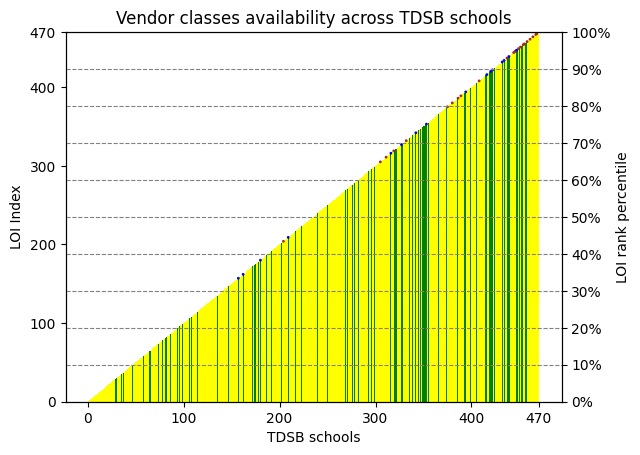

In [44]:
# Show the plot
plt.show()

#### Show all schools with extracurriculars offered by the vendor. Break them down by their LOI index bucket and presence of Early French Immersion stream

##### Prepare chart data

In [45]:
# Get a series of buckets
rank_bucket_list_fi = [x["rank_bucket"] for x in dfs_full_buckets_c.select("rank_bucket").filter("fi_ind = 1").collect()]
rank_bucket_list_nfi = [x["rank_bucket"] for x in dfs_full_buckets_c.select("rank_bucket").filter("fi_ind = 0").collect()]
print(rank_bucket_list_fi)
print(rank_bucket_list_nfi)

# Get a series of bucket counts
rank_count_list = [x["count"] for x in dfs_buckets_c.select("count").collect()]
rank_count_list_fi = [x["count"] for x in dfs_full_buckets_c.select("count").filter("fi_ind = 1").collect()]
rank_count_list_nfi = [x["count"] for x in dfs_full_buckets_c.select("count").filter("fi_ind = 0").collect()]
print(rank_count_list)
print(rank_count_list_fi)
print(rank_count_list_nfi)

# Generate ticks and labels for buckets
bucket_ticks_values = [x for x in range(0,11)]
bucket_ticks_labels = [str(x*10) + "%" for x in bucket_ticks_values]

# Generate ticks and labels for bucket counts
bucket_count_ticks_values = set(rank_count_list)
bucket_count_ticks_values.add(0)
bucket_count_ticks_values = list(range(0,max(rank_count_list)+1))
bucket_count_ticks_labels = [str(x) for x in bucket_count_ticks_values]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[3, 2, 5, 4, 8, 17]
[0, 0, 0, 3, 1, 0, 2, 2, 4, 4]
[0, 0, 0, 0, 1, 0, 3, 2, 4, 13]


##### Prepare the chart

In [46]:
# turn off interactive mode (the actual chart will be in the next cell)
plt.ioff()

# create plot objects
fig, ax = plt.subplots()

# Set the limits of the plot
ax.set_xlim(0, 10)
ax.set_ylim(0, max(rank_count_list))

# Set the ticks and labels for x and y axes
ax.set_xticks(bucket_ticks_values)
ax.set_xticklabels(bucket_ticks_labels)
ax.set_yticks(bucket_count_ticks_values)
ax.set_yticklabels(bucket_count_ticks_labels)

# Adding horizontal grid lines at percentage ticks
ax.grid(which='major', axis='y', linestyle='--', color='grey')

# Labeling the axes
ax.set_xlabel('LOI Index percentile buckets')
ax.set_ylabel('Number of schools with vendor classes')

# Set the title
ax.set_title('Schools with vendor classes grouped by LOI Index percentile')

# Plot the bar chart (with all schools and their index)
ax.bar(rank_bucket_list_fi, rank_count_list_fi, 1, align='edge', color="brown", edgecolor="black")
ax.bar(rank_bucket_list_nfi, rank_count_list_nfi, 1, bottom = rank_count_list_fi, align='edge', color="yellow", edgecolor="black")



<BarContainer object of 10 artists>

##### Show the chart


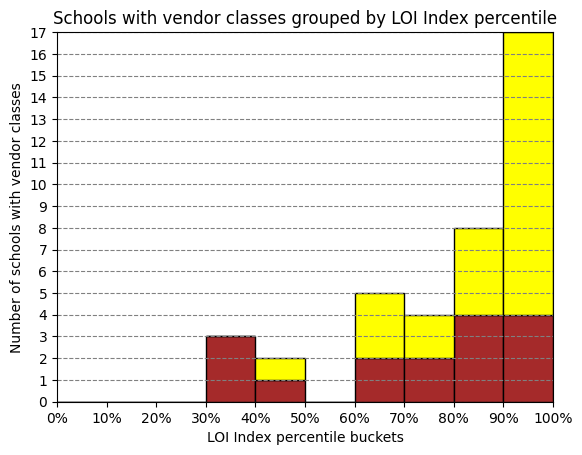

In [47]:
# Show the plot
plt.show()

#### Show a Venn diagram for subsets of schools with LOI index, with FI stream, with extracurriculars offered by the vendor

###### Prepare chart data

In [48]:
# calulate all subset sizes to use for Venn diagram
loi_nf_nv_cnt = dfs_full.filter("loi_rank is not NULL and fi_school_id is null and vendor_school_id is NULL").count()
nloi_f_nv_cnt = dfs_full.filter("loi_rank is NULL and fi_school_id is not null and vendor_school_id is NULL").count()
loi_f_nv_cnt = dfs_full.filter("loi_rank is not NULL and fi_school_id is not null and vendor_school_id is NULL").count()
nloi_nf_v_cnt = dfs_full.filter("loi_rank is NULL and fi_school_id is null and vendor_school_id is not NULL").count()
loi_nf_v_cnt = dfs_full.filter("loi_rank is not NULL and fi_school_id is null and vendor_school_id is not NULL").count()
nloi_f_v_cnt = dfs_full.filter("loi_rank is NULL and fi_school_id is not null and vendor_school_id is not NULL").count()
loi_f_v_cnt = dfs_full.filter("loi_rank is not NULL and fi_school_id is not null and vendor_school_id is not NULL").count()


In [49]:
all_tdsb_schools = loi_nf_nv_cnt + loi_f_nv_cnt + loi_nf_v_cnt + loi_f_v_cnt
all_tdsb_schools_with_vendor = loi_nf_v_cnt + loi_f_v_cnt
ratio_all_tdsb_schools_with_vendor = (all_tdsb_schools_with_vendor / all_tdsb_schools)*100
all_tdsb_fi_schools = loi_f_nv_cnt + loi_f_v_cnt
all_tdsb_fi_schools_with_vendor = loi_f_v_cnt
ratio_all_tdsb_fi_schools_with_vendor = (all_tdsb_fi_schools_with_vendor / all_tdsb_fi_schools)*100
print(ratio_all_tdsb_schools_with_vendor)
print(ratio_all_tdsb_fi_schools_with_vendor)

8.297872340425531
16.842105263157894


###### Prepare the chart

In [50]:
venn3(subsets = (loi_nf_nv_cnt,nloi_f_nv_cnt,loi_f_nv_cnt,nloi_nf_v_cnt,
                 loi_nf_v_cnt,nloi_f_v_cnt,loi_f_v_cnt),
      set_labels = ('TSDB schools with LOI index', 'TDSB schools with FI', 'Schools with vendor extracurriculars'))

###### Show the chart

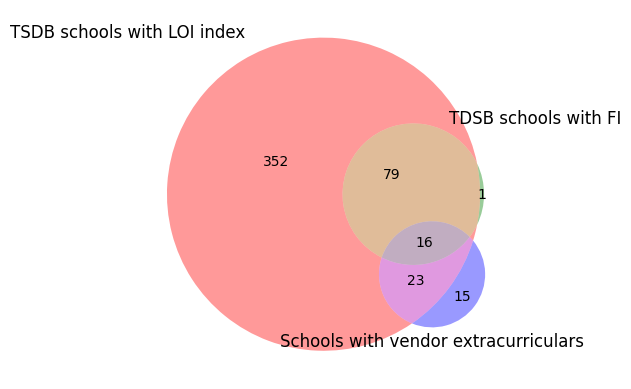

In [51]:
plt.show()